In [2]:
import pandas as pd
import numpy as np
import folium
import datetime
import json

# Meer regels laten zien in jupyter
pd.set_option('display.max_rows', 100)

De [Functiekaart](https://maps.amsterdam.nl/functiekaart/?LANG=nl) op maps.amsterdam.nl toont de functie van gebouwen die geen woningen zijn. Voor het prototype matching willen wij verschillende categoriën hieruit filteren, en de data in een werkbaar bestand omzetten.

In [3]:
# CSV inlezen
df = pd.read_csv('https://maps.amsterdam.nl/open_geodata/excel.php?KAARTLAAG=FUNCTIEKAART&THEMA=functiekaart', delimiter=';')

## Data bekijken

In [4]:
# Even kijken
df.head()

,OBJECTNUMMER,FUNCTIE2_OMS,ZAAKNAAM,FUNCTIE2_ENG,FUNCTIE1_ID,FUNCTIE1_OMS,FUNCTIE1_ENG,FUNCTIE2_ID,LAAG,ADRESSEN_LIJST,ADRESSEN_VOT,ADRESSEN_AANTAL,OPPERVLAKTE_SOM,OPPERVLAKTE_NUL,CHECKDATUM,ZAAK_ID,COORDS,LNG,LAT,Unnamed: 19
0,2,Bedrijf - Bedrijfsverzamelgebouw,GATES MODEONTWERPSTER,Enterprise - Collective enterprises,B,Bedrijven,Enterprises,B01,1,Eerste Constantijn Huygensstraat 72/H - 159 m2...,03630001026781-03630001026782,2,209,0,2017-03-10,4814,"POLYGON((4.874287 52.363621,4.87442 52.363659,...","4,874385","52,3635735",NaN
1,3,Bedrijf - Bedrijfsverzamelgebouw,AUTOBEDRIJF,Enterprise - Collective enterprises,B,Bedrijven,Enterprises,B01,1,Tweede Helmersstraat 11/H - 114 m2<br>Tweede H...,03630000550443-03630001015240,2,281,0,2017-02-22,4864,"POLYGON((4.87776 52.364755,4.877969 52.364816,...","4,877916","52,364678",NaN
2,4,Bedrijf - Bedrijfsverzamelgebouw,GARAGE WEST-CENTER,Enterprise - Collective enterprises,B,Bedrijven,Enterprises,B01,1,Tweede Helmersstraat 15/H - 0 m2<br>,03630000550458,1,0,1,2017-02-22,4866,"POLYGON((4.87776 52.364755,4.877905 52.364564,...","4,8777875","52,3646325",NaN
3,5,Bedrijf - Bedrijfsverzamelgebouw,HELMER GARAGE,Enterprise - Collective enterprises,B,Bedrijven,Enterprises,B01,1,Tweede Helmersstraat 47/H - 61 m2<br>,03630022623974,1,61,0,2017-02-22,4868,"POLYGON((4.876384 52.364241,4.876314 52.364331...","4,8763965","52,364285",NaN
4,6,Bedrijf - Bedrijfsverzamelgebouw,AUTOSERVICE,Enterprise - Collective enterprises,B,Bedrijven,Enterprises,B01,1,Tweede Kostverlorenkade 23/H - 0 m2<br>Tweede ...,03630000552251-03630001009796-03630000552258,3,272,1,2017-07-10,4873,"POLYGON((4.865257 52.369879,4.865419 52.369823...","4,8653035","52,3697365",NaN


In [5]:
# Group en sum de soorten gebouwen in hoofdfuncties en subfuncties
df.groupby(['FUNCTIE1_OMS','FUNCTIE2_OMS']).size()

FUNCTIE1_OMS                FUNCTIE2_OMS                                                
Activiteiten en Ontmoeting  Badhuis - Hamam - Sauna                                           13
                            Camping - Jachthaven - Stadsstrand                                49
                            Kinderboerderij - Speeltuin - Jeugdwerkterrein - Scouting         77
                            Ontmoetings- en activiteitencentrum                              277
                            Openbare bibliotheek                                              29
                            Volkstuinpark - Natuurtuin - Schoolwerktuin                       60
                            Vrijetijdslessen - Hobbyvereniging - Oefenruimte                 134
Bedrijven                   Agrarisch bedrijf - Bedrijf in/met kassen                         66
                            Bedrijf - Bedrijfsverzamelgebouw                                4083
                            Broedplaat

In [6]:
# Alleen count van hoofdfuncties
df.groupby(['FUNCTIE1_OMS']).size()

FUNCTIE1_OMS
Activiteiten en Ontmoeting     639
Bedrijven                     4549
Detailhandel                  8732
Horeca                        4775
Kantoren                      4497
Onderwijs                     1096
Onduidelijk                    969
Openbaar vervoer                35
Parkeren                       243
Religie                        289
Sport                          524
Uitgaan en Toerisme            330
Zorg                          1511
dtype: int64

## Data selecteren, platslaan naar 1 categorie, titles correct capitalizen

In [7]:
# CSV inlezen
df = pd.read_csv('https://maps.amsterdam.nl/open_geodata/excel.php?KAARTLAAG=FUNCTIEKAART&THEMA=functiekaart', delimiter=';')

In [8]:
# Converteer LAT LNG columns naar een punt als decimal
df['lon'] = pd.to_numeric(df['LNG'].str.replace(',','.'))
df['lat'] = pd.to_numeric(df['LAT'].str.replace(',','.'))

# Categorieën die we gaan uitsluiten (waardes van de FUNCTIE1_OMS kolom)
nietrelevant_FUNCTIE1_OMS = 'Bedrijven|Kantoren|Openbaar vervoer|Parkeren'

# Subcategorien die we gaan uitsluiten (waardes van de FUNCTIE2_OMS kolom)
nietrelevant_FUNCTIE2_OMS = 'Opstappunt rondvaart - waterfiets|Onduidelijk'

# Kolommen die we willen behouden
# 'ADRESSEN_LIJST'
relevante_kolommen = ['FUNCTIE1_OMS', 'FUNCTIE2_OMS', 'ZAAKNAAM', 'lon', 'lat', 'ZAAK_ID']

# Nieuwe dataframe zonder niet relevante data
df_filtered = df[relevante_kolommen]
df_filtered = df_filtered[~df_filtered['FUNCTIE1_OMS'].str.contains(nietrelevant_FUNCTIE1_OMS, na=False)]
df_filtered = df_filtered[~df_filtered['FUNCTIE2_OMS'].str.contains(nietrelevant_FUNCTIE2_OMS, na=False)]
df_filtered = df_filtered.fillna('')

# Hernoem detailhandel naar winkel, horeca naar overige horeca
# We houden cafés en coffeeshops apart van horeca
df_filtered['cat'] = df_filtered['FUNCTIE1_OMS']
df_filtered['cat'] = df_filtered['cat'].replace({'Detailhandel':'Winkels', 'Horeca': 'Horeca - Overig'})
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Café - Eetcafé', 'cat'] = "Cafés"
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Coffeeshop', 'cat'] = "Coffeeshops"

# Zelfde voor uitgaan: gokken, bioscopen en bordelen eruit
df_filtered['cat'] = df_filtered['cat'].replace({'Uitgaan en Toerisme': 'Uitgaan en Toerisme - Overig'})
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Automatenhal - Casino', 'cat'] = "Gokhal"
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Bioscoop - Filmhuis', 'cat'] = "Bioscoop"
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Bordeel - Raamprostitutie - Sexclub', 'cat'] = "Prostitutie"

# Zelfde voor zorg: dag- en nachtopvang eruit
df_filtered['cat'] = df_filtered['cat'].replace({'Zorg': 'Zorg - Overig'})
df_filtered.loc[df_filtered['FUNCTIE2_OMS'] == 'Dag- en nachtopvang', 'cat'] = "Dag- en nachtopvang"

# Output filtered vs hele dataset, telling en output waarden eerste keer draaien script
print('Waarde 2018-07-20:')
print('18900 objecten (filtered) vs 28189 (hele dataset)')
print('Waarde ' + str(datetime.datetime.today()).split()[0] + ':')
print(str(len(df_filtered)) + " objecten (filtered) vs " + str(len(df)) + " (hele dataset)")

# Titlecase names with a locally adjusted version of the titlecase 
# module: https://github.com/ppannuto/python-titlecase
from titlecase import titlecase

def title_exceptions(word, **kwargs):
#     print(word)
    if word.upper() in ('BV', 'AKO','AH','PT020', 'IJ', 'VTP', 'ID', 'TV', 'HTML', 'XML', "URL", "HTTP", "VPN"):
        return word.upper()
    if word.upper() in ('VOF'):
        return word.lower()
    if "IJ" in word[:2]:
        return word.lower().replace('ij', 'IJ')

df_filtered['name'] = df_filtered['ZAAKNAAM'].apply((lambda x: titlecase(x, callback=title_exceptions)))

# Only keep what we need, rename columns
df_final = df_filtered[['name', 'cat', 'lon', 'lat', 'ZAAK_ID']].copy()
df_final.columns = ['name', 'cat', 'lon', 'lat', 'zaak_id']

# Write to JSON as records
df_final.to_json('../src/assets/functies.json', orient="records")

Waarde 2018-07-20:
18900 objecten (filtered) vs 28189 (hele dataset)
Waarde 2018-12-04:
17875 objecten (filtered) vs 28189 (hele dataset)


In [9]:
df_final

,name,cat,lon,lat,zaak_id
5,Kalender Kleermaker,Winkels,4.867670,52.368443,4915
40,Willems Vintage Bikes,Winkels,4.859497,52.372618,5995
59,Gezichtsreflexologie,Zorg - Overig,4.856788,52.364427,6398
65,Eva,Winkels,4.877404,52.364537,6533
66,Kas Keerweer,Activiteiten en Ontmoeting,4.863919,52.370215,6542
150,Irenes Hobby Hoek,Winkels,4.872100,52.383195,8912
164,De IJstuin,Horeca - Overig,4.884196,52.343556,11340
172,Mili Goros,Activiteiten en Ontmoeting,4.805510,52.374396,11848
194,Las Reisbureau,Winkels,4.852830,52.389882,11924
206,Geveke Werktuigbouw,Winkels,4.856409,52.394005,11947


## Op een kaart plotten

In [10]:
amsterdam_centraal = [52.3702, 4.8952]
huidige_locatie = [52.38200068197066, 4.87652430311739]
slijterijen_zaaknaam = 'SLIJTER|GALL & GALL'

m = folium.Map(
    location = amsterdam_centraal,
    zoom_start = 13,
#     tiles='Stamen Terrain'
)


for index, row in df_filtered[df['ZAAKNAAM'].str.contains(slijterijen_zaaknaam, na=False) | df_filtered['FUNCTIE2_OMS'].str.contains('Supermarkt groot', na=False)].iterrows():
    folium.Marker(
    location=[float(row['lat']), float(row['lon'])],
    popup=row['ZAAKNAAM'],
    icon=folium.Icon(color='green')).add_to(m)

folium.Marker(
    location=[float(huidige_locatie[0]), float(huidige_locatie[1])],
    popup='Huidige locatie',
    icon=folium.Icon(icon='cloud', color='red')).add_to(m)
    
    
m

/Users/jurian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [14]:
import seaborn as sns


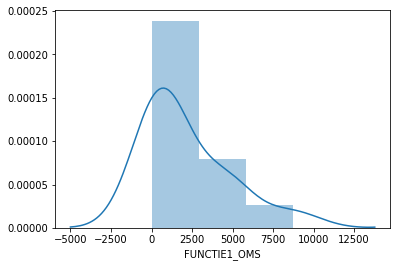

In [15]:
sns.distplot(df['FUNCTIE1_OMS'].T.value_counts())

In [16]:
df_filtered

,FUNCTIE1_OMS,FUNCTIE2_OMS,ZAAKNAAM,lon,lat,ZAAK_ID,cat,name
5,Detailhandel,Consumentendienstverlening overig,KALENDER KLEERMAKER,4.867670,52.368443,4915,Winkels,Kalender Kleermaker
40,Detailhandel,Winkel overig,WILLEMS VINTAGE BIKES,4.859497,52.372618,5995,Winkels,Willems Vintage Bikes
59,Zorg,Gezondheidspraktijk,GEZICHTSREFLEXOLOGIE,4.856788,52.364427,6398,Zorg - Overig,Gezichtsreflexologie
65,Detailhandel,Galerie - Kunstuitleen,EVA,4.877404,52.364537,6533,Winkels,Eva
66,Activiteiten en Ontmoeting,Volkstuinpark - Natuurtuin - Schoolwerktuin,KAS KEERWEER,4.863919,52.370215,6542,Activiteiten en Ontmoeting,Kas Keerweer
150,Detailhandel,Winkel overig,IRENES HOBBY HOEK,4.872100,52.383195,8912,Winkels,Irenes Hobby Hoek
164,Horeca,Snackbar - IJssalon - Viskraam - Food-to-go,DE IJSTUIN,4.884196,52.343556,11340,Horeca - Overig,De IJstuin
172,Activiteiten en Ontmoeting,Ontmoetings- en activiteitencentrum,MILI GOROS,4.805510,52.374396,11848,Activiteiten en Ontmoeting,Mili Goros
194,Detailhandel,Consumentendienstverlening overig,LAS REISBUREAU,4.852830,52.389882,11924,Winkels,Las Reisbureau
206,Detailhandel,Winkel overig,GEVEKE WERKTUIGBOUW,4.856409,52.394005,11947,Winkels,Geveke Werktuigbouw


In [17]:
df_filtered.to_json('flat.json', orient="records")

In [19]:
df_filtered

,FUNCTIE1_OMS,FUNCTIE2_OMS,ZAAKNAAM,lon,lat,ZAAK_ID,cat,name
5,Detailhandel,Consumentendienstverlening overig,KALENDER KLEERMAKER,4.867670,52.368443,4915,Winkels,Kalender Kleermaker
40,Detailhandel,Winkel overig,WILLEMS VINTAGE BIKES,4.859497,52.372618,5995,Winkels,Willems Vintage Bikes
59,Zorg,Gezondheidspraktijk,GEZICHTSREFLEXOLOGIE,4.856788,52.364427,6398,Zorg - Overig,Gezichtsreflexologie
65,Detailhandel,Galerie - Kunstuitleen,EVA,4.877404,52.364537,6533,Winkels,Eva
66,Activiteiten en Ontmoeting,Volkstuinpark - Natuurtuin - Schoolwerktuin,KAS KEERWEER,4.863919,52.370215,6542,Activiteiten en Ontmoeting,Kas Keerweer
150,Detailhandel,Winkel overig,IRENES HOBBY HOEK,4.872100,52.383195,8912,Winkels,Irenes Hobby Hoek
164,Horeca,Snackbar - IJssalon - Viskraam - Food-to-go,DE IJSTUIN,4.884196,52.343556,11340,Horeca - Overig,De IJstuin
172,Activiteiten en Ontmoeting,Ontmoetings- en activiteitencentrum,MILI GOROS,4.805510,52.374396,11848,Activiteiten en Ontmoeting,Mili Goros
194,Detailhandel,Consumentendienstverlening overig,LAS REISBUREAU,4.852830,52.389882,11924,Winkels,Las Reisbureau
206,Detailhandel,Winkel overig,GEVEKE WERKTUIGBOUW,4.856409,52.394005,11947,Winkels,Geveke Werktuigbouw
